### HW2 for Fixed-income Quantitative Trading

** Xingyue Huang (N14034682) **
* The hw2 is coded under Python 2 environment
* And system may suggest the use of 'loc' instead of 'iloc' via Warnings repeatedly, yet codes are running smoothly without errors
* Also, the result summaries and package methodologies are given right above/below relevant code sections, not the bottom of the whole codes.

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as tsa
from sklearn.linear_model import LinearRegression
from scipy.linalg import sqrtm

# read CMT file and perform pre data processing
data_raw = pd.read_excel('CMT-all.xlsx')
data_raw.set_index('Date', inplace=True)
data = data_raw[['3M', '2Y', '5Y', '7Y', '10Y', '30Y']]
print data.head() # display the first five rows of the data

sample1 = data.loc['2013-01-02':'2015-01-02',:]
sample2 = data.loc['2015-01-02':'2017-01-03',:]
assert ~sample1.isnull().values.any(), 'Warning: Sample1 still has NaN values.'
assert ~sample2.isnull().values.any(), 'Warning: Sample2 still has NaN values.'

              3M    2Y    5Y    7Y   10Y   30Y
Date                                          
1990-01-02  7.83  7.87  7.87  7.98  7.94  8.00
1990-01-03  7.89  7.94  7.92  8.04  7.99  8.04
1990-01-04  7.84  7.92  7.91  8.02  7.98  8.04
1990-01-05  7.79  7.90  7.92  8.03  7.99  8.06
1990-01-08  7.79  7.90  7.92  8.05  8.02  8.09


In [7]:
for col in ['3M', '2Y', '5Y', '7Y', '10Y', '30Y']:
    sample1[col+'dR'] = sample1[col].diff()
    sample2[col+'dR'] = sample2[col].diff()
sample1 = sample1.dropna()
sample2 = sample2.dropna()
print sample1.head()

/Users/huangxingyue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/huangxingyue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


              3M    2Y    5Y    7Y   10Y   30Y  3MdR  2YdR  5YdR  7YdR  10YdR  \
Date                                                                            
2013-01-03  0.08  0.27  0.81  1.31  1.92  3.12  0.00  0.00  0.05  0.06   0.06   
2013-01-04  0.07  0.27  0.82  1.32  1.93  3.10 -0.01  0.00  0.01  0.01   0.01   
2013-01-07  0.07  0.27  0.82  1.31  1.92  3.10  0.00  0.00  0.00 -0.01  -0.01   
2013-01-08  0.07  0.25  0.79  1.28  1.89  3.06  0.00 -0.02 -0.03 -0.03  -0.03   
2013-01-09  0.06  0.24  0.77  1.27  1.88  3.06 -0.01 -0.01 -0.02 -0.01  -0.01   

            30YdR  
Date               
2013-01-03   0.08  
2013-01-04  -0.02  
2013-01-07   0.00  
2013-01-08  -0.04  
2013-01-09   0.00  


#### On PCA
Here I calculated PCA myself instead of turning to packages. 

The basic idea of PCA is to find the eigenvactors whose corresponding eigenvalues are among the biggest from covariance matrix.

First I calculated the covariance matrix of sample1 and then found its eigenvalues and eigenvectors. Next, sort the eigen pairs by eigenvalues in a decreasing order.

The first three components are displayed and plotted with their explained variances.

First three components of key rates: 
[[ 0.00263926 -0.00593215  0.02786976]
 [ 0.17858983 -0.5010828   0.82240587]
 [ 0.47970193 -0.46636445 -0.21745329]
 [ 0.53852142 -0.15542701 -0.32887641]
 [ 0.50494771  0.18852252 -0.08239828]
 [ 0.4393259   0.68679455  0.40079516]] 



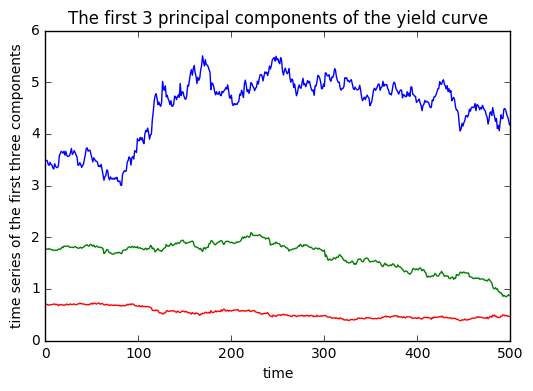

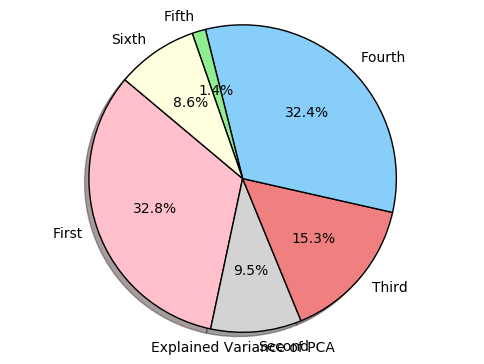

In [8]:
# perform PCA on sample1 for rates
cov_1 = sample1.iloc[:,6:].cov() # calculate the covariance matrix of sample1 based on returnsprint(cov_1)
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_1) # calculate eigenvalues and eigenvectors of cov_1
for ev in eig_vec_cov: # assert the correctness of calculation
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))# make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
eig_pairs.sort(key=lambda x: x[0], reverse=True) # sort the (eigenvalue, eigenvector) tuples from high to low

matrix_w = np.hstack((eig_pairs[0][1].reshape(6,1), eig_pairs[1][1].reshape(6,1), eig_pairs[2][1].reshape(6,1)))
print 'First three components of key rates: \n', matrix_w, '\n'

# plot time series of the first 3 principal components
ts_3c = np.dot(sample1.iloc[:,:6].values, matrix_w)
plt.plot(ts_3c)
plt.xlabel('time')
plt.ylabel('time series of the first three components')
plt.title('The first 3 principal components of the yield curve')
plt.show()

# display and plot explained variances of PCA
var_list = []
for i in range(6):
    var_list.append(np.var(np.dot(sample1.iloc[:,:6].values, eig_vec_cov[i].reshape(6,1))))
var_agg = sum(var_list)
var_pct = [item / var_agg for item in var_list]

colors = ['pink', 'lightgrey', 'lightcoral', 'lightskyblue', 'lightgreen', 'lightyellow']
labels = 'First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth'
plt.pie(var_pct, autopct='%1.1f%%', colors=colors, labels = labels, shadow=True, startangle=140)
plt.axis('equal')
plt.ylabel('Explained Variance of PCA')
plt.show()

In [3]:
# calculate FLY(2y-5y+10y) for sample1 & sample2
sample1.loc[:, 'FLY'] = sample1.loc[:, '2Y'] - sample1.loc[:, '5Y'] + sample1.loc[:, '10Y']
sample2.loc[:, 'FLY'] = sample2.loc[:, '2Y'] - sample2.loc[:, '5Y'] + sample2.loc[:, '10Y']

# find weights for PCA FLY
eig_vec_1 = eig_pairs[0][1]
eig_vec_2 = eig_pairs[1][1]
a = np.array([[eig_vec_1[2]], [eig_vec_2[2]]])
b = np.linalg.inv(np.array([[eig_vec_1[1], eig_vec_1[4]], [eig_vec_2[1], eig_vec_2[4]]]))
w1, w2 = np.dot(b, a)[0][0], np.dot(b, a)[1][0]

# calculate PCA FLY(2y-5y+10y) for sample1 & sample2
sample1.loc[:, 'PCA FLY'] = sample1.loc[:, '2Y'] * w1 - sample1.loc[:, '5Y'] + sample1.loc[:, '10Y'] * w2
sample2.loc[:, 'PCA FLY'] = sample2.loc[:, '2Y'] * w1 - sample2.loc[:, '5Y'] + sample2.loc[:, '10Y'] * w2

/Users/huangxingyue/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/huangxingyue/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#### On ADF tests for FLY & PCA FLY on sample1 and sample2
Here I used the package 'statsmodels' to perform ADF test.

ADF test examines whether a time series is stationary via calculating its unit roots. It all the unit roots are outside unit circle, the time series is stationary; otherwise not.

The ordinary FLY on both training and test samples are far from stationary (p-values are above 0.6).

The PCA FLY on training sample(sample1) is stationary (p-value=0.0019 << 0.01), which also demonstrates that the first two components calculated on sample1 are adequately explainatory of sample1. On the other hand, the PCA FLY on test sample is ill-behaved with p-value above 0.84. *This shows the instability of key rates of the yield curve.* 

In [4]:
# compute ADF test statistic for FLY & PCA FLY in sample 1 & sample2, 20 pts
adf_sample1_fly = tsa.adfuller(sample1['FLY'])
print 'adf of sample1_fly: ', adf_sample1_fly[0]
print 'p-value of sample1_fly: ', adf_sample1_fly[1]
print 'critical values of sample1_fly: ', adf_sample1_fly[4], '\n'

adf_sample1_pcafly = tsa.adfuller(sample1['PCA FLY'])
print 'adf of sample1_pcafly: ', adf_sample1_pcafly[0] 
print 'p-value of sample1_pcafly: ', adf_sample1_pcafly[1]
print 'critical values of sample1_pcafly: ', adf_sample1_pcafly[4], '\n'

adf_sample2_fly = tsa.adfuller(sample2['FLY'])
print 'adf of sample2_fly: ', adf_sample2_fly[0]
print 'p-value of sample2_fly: ', adf_sample2_fly[1]
print 'critical values of sample2_fly: ', adf_sample2_fly[4], '\n'

adf_sample2_pcafly = tsa.adfuller(sample2['PCA FLY'])
print 'adf of sample2_pcafly: ', adf_sample2_pcafly[0]
print 'p-value of sample2_pcafly: ', adf_sample2_pcafly[1]
print 'critical values of sample2_pcafly: ', adf_sample2_pcafly[4], '\n'

adf of sample1_fly:  -1.16649887314
p-value of sample1_fly:  0.687838541778
critical values of sample1_fly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample1_pcafly:  -3.91297949627
p-value of sample1_pcafly:  0.00194137470087
critical values of sample1_pcafly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample2_fly:  -1.12848719691
p-value of sample2_fly:  0.703578899213
critical values of sample2_fly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample2_pcafly:  -0.739523497801
p-value of sample2_pcafly:  0.83624479094
critical values of sample2_pcafly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 



#### On CCA based on Box & Tiao (1977)
Here I performed CCA according to Box & Tiao (1977).

It finds linear combinations of variables ranked in order of predictability by computing eigenvectors of Q (the matrix measure of predictibility). The compnents/eigenvectors corresponding to larger eigenvalues have better predictibility while those corresponding to smaller eigenvalues have worse and thus depend less on the past, which means more stationary.

I use the eigenvector corresponding the least eigenvalue of Q to calculate weights for COINT FLY CCA and performed ADF test. According to the ADF test, the COINT FLY with CCA Box & Tiao method is stationary with pvalue = 0.0016 << 0.01 on sample1 while it is far from stationary on sample 2 with pvalue=0.83.

In [5]:
# perform cointegration analysis either by Box-Tiao or Chou-Ng in Sample1, 20 pts
sub1 = sample1.loc[:,['2Y','5Y','10Y']]
sub2 = sample2.loc[:,['2Y','5Y','10Y']]
X = sub1.iloc[:-1,:]
Y = sub1.iloc[1:,:] # Y is the first-order lag of X
A = np.linalg.lstsq(X,Y)[0] # least square solution to Y = X*A
C = sub1.cov() # covariance matrix of X/Y
Q = np.dot(np.linalg.inv(C),np.dot(A.T, np.dot(C, A))) # measure of relative predictibility according to Box & Tiao
eig_val_cov, eig_vec_cov = np.linalg.eig(Q) # calculate eigenvalues and eigenvectors of Q
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
eig_pairs.sort(key=lambda x: x[0], reverse=False) # sort the (eigenvalue, eigenvector) tuples from low to high
print 'least-square solution to Y = X*A: \n', A, '\n'
print 'measure of relative predictibility Q: \n', Q, '\n'
print 'eig_pairs of Q sorted by eigenvalues: \n', eig_pairs, '\n'
print 'eigen_values of Q: \n', eig_val_cov, '\n'
print 'eigen_vectors / factor loadings: \n', eig_vec_cov, '\n'

least-square solution to Y = X*A: 
[[  9.72418775e-01  -2.64458311e-02  -2.38328551e-02]
 [  9.42715606e-03   9.94587880e-01  -1.04585449e-02]
 [ -8.88201328e-04   7.79375338e-03   1.00980837e+00]] 

measure of relative predictibility Q: 
[[ 0.96034005  0.18949259  0.30718674]
 [ 0.0156089   0.89259189 -0.16785095]
 [-0.00883283  0.05973855  1.1025232 ]] 

eig_pairs of Q sorted by eigenvalues: 
[(0.94123994530980093, array([ 0.88448461, -0.41966559,  0.20388175])), (0.99127752090854082, array([-0.96435393, -0.25734066,  0.06162205])), (1.0229376762982001, array([ 0.72925888, -0.5059142 ,  0.46068677]))] 

eigen_values of Q: 
[ 0.94123995  0.99127752  1.02293768] 

eigen_vectors / factor loadings: 
[[ 0.88448461 -0.96435393  0.72925888]
 [-0.41966559 -0.25734066 -0.5059142 ]
 [ 0.20388175  0.06162205  0.46068677]] 



In [6]:
# calculate weights for COINT FLY CCA according to Box & Tiao
C_sqrtinv = np.linalg.inv(sqrtm(C))
#w = np.dot(C_sqrtinv, eig_pairs[0][1].reshape(3,1))
w = [0.88448461, -0.41966559,  0.20388175]
w = np.array([-w[0]/w[1],-1,-w[2]/w[1]])
coint_fly1 = np.dot(sub1.values, w)
coint_fly2 = np.dot(sub2.values, w)
sample1['COINT FLY CCA'] = coint_fly1
sample2['COINT FLY CCA'] = coint_fly2

# perform ADF test on COINT FLY CCA in sample1&2
adf_sample1_cointflycca = tsa.adfuller(sample1['COINT FLY CCA'])
print 'adf of sample1_cointfly: ', adf_sample1_cointflycca[0]
print 'p-value of sample1_cointfly: ', adf_sample1_cointflycca[1]
print 'critical values of sample1_cointfly: ', adf_sample1_cointflycca[4], '\n'

adf_sample2_cointflycca = tsa.adfuller(sample2['COINT FLY CCA'])
print 'adf of sample1_pcafly: ', adf_sample2_cointflycca[0] 
print 'p-value of sample1_pcafly: ', adf_sample2_cointflycca[1]
print 'critical values of sample1_pcafly: ', adf_sample2_cointflycca[4]

adf of sample1_cointfly:  -2.59661238022
p-value of sample1_cointfly:  0.0936994428584
critical values of sample1_cointfly:  {'5%': -2.8673612117611267, '1%': -3.4435494520411605, '10%': -2.5698704830567247} 

adf of sample1_pcafly:  -0.670275876892
p-value of sample1_pcafly:  0.854299276852
critical values of sample1_pcafly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056}


/Users/huangxingyue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/huangxingyue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
w

array([ 2.10759383, -1.        ,  0.48581955])

#### Use level regression to find COINT FLY
Here I used the package 'sckit-learn' to perform linear regression on level rates and find weights for COINT FLY.

The basic idea for linear regression is to find the coefficient for independent variables that can best explain dependent variables under least squares or maximum likelihood.

The coefficients here are weights for COINT FLY because if 2Y, 5Y, 10Y have cointegration relationship, there must exist a stationary linear combination of the three, which is exactly the residue of linear regression best modelled.

In [7]:
# calculate COINT FLY REG for sample1 & sample2, 5 pts
lr = LinearRegression()
lr.fit(sample1[['2Y','10Y']], sample1['5Y'])
w3_, w4_ = lr.coef_ # find weights for COINT FLY via level regression
sample1.loc[:,'COINT FLY REG'] = sample1.loc[:, '2Y'] * w3_ - sample1.loc[:, '5Y'] + sample1.loc[:, '10Y'] * w4_
sample2.loc[:,'COINT FLY REG'] = sample2.loc[:, '2Y'] * w3_ - sample2.loc[:, '5Y'] + sample2.loc[:, '10Y'] * w4_

#### On ADF tests for COINT FLY on sample1 and sample2
The COINT FLY is also stationary on sample1 with p-value = 0.003 << 0.01 while not on sample2 with p-value = 0.84.

This shows that the linear model is overfitting in training sample and requires some methods to prevent that such as variable reduction, ridge regression/LASSO.

This again proves the instability of key rates of the yield curve.

In [8]:
# compute ADF test statistics for COINT FLY in sample1 & sample2, 10 pts
adf_sample1_cointflyreg = tsa.adfuller(sample1['COINT FLY REG'])
print 'adf of sample1_cointfly: ', adf_sample1_cointflyreg[0]
print 'p-value of sample1_cointfly: ', adf_sample1_cointflyreg[1]
print 'critical values of sample1_cointfly: ', adf_sample1_cointflyreg[4], '\n'

adf_sample2_cointflyreg = tsa.adfuller(sample2['COINT FLY REG'])
print 'adf of sample1_pcafly: ', adf_sample2_cointflyreg[0] 
print 'p-value of sample1_pcafly: ', adf_sample2_cointflyreg[1]
print 'critical values of sample1_pcafly: ', adf_sample2_cointflyreg[4]

adf of sample1_cointfly:  -3.79207482615
p-value of sample1_cointfly:  0.00298944868216
critical values of sample1_cointfly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample1_pcafly:  -0.734984394781
p-value of sample1_pcafly:  0.837478528006
critical values of sample1_pcafly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056}


In [9]:
print 'sample1: \n', sample1.head(), '\n'
print 'Weights:'
print 'PCA FLY: ', w1, -1, w2
print 'COINT FLY CCA: ', w[0], -1, w[2]
print 'COINT FLY REG: ', w3_, -1, w4_, '\n'
print 'P-values:'
print 'PCA FLY: ', adf_sample1_pcafly[1]
print 'COINT FLY CCA: ', adf_sample1_cointflycca[1]
print 'COINT FLY REG: ', adf_sample1_cointflyreg[1]

sample1: 
              3M    2Y    5Y    7Y   10Y   30Y   FLY   PCA FLY  COINT FLY CCA  \
Date                                                                            
2013-01-02  0.08  0.27  0.76  1.25  1.86  3.04  1.37  0.913109       0.940255   
2013-01-03  0.08  0.27  0.81  1.31  1.92  3.12  1.38  0.899401       0.927335   
2013-01-04  0.07  0.27  0.82  1.32  1.93  3.10  1.38  0.895450       0.923515   
2013-01-07  0.07  0.27  0.82  1.31  1.92  3.10  1.37  0.889401       0.917335   
2013-01-08  0.07  0.25  0.79  1.28  1.89  3.06  1.35  0.860659       0.887998   

            COINT FLY REG  
Date                       
2013-01-02       0.898891  
2013-01-03       0.886477  
2013-01-04       0.882741  
2013-01-07       0.876477  
2013-01-08       0.851111   

Weights:
PCA FLY:  2.02981664314 -1 0.604870270597
COINT FLY CCA:  [ 2.03984081] -1 [ 0.61800956]
COINT FLY REG:  1.82860820591 -1 0.626433493221 

P-values:
PCA FLY:  0.00194137470087
COINT FLY CCA:  0.00155697505282
COINT 

#### Summaries on three weighted FLY
From the section just above, we can see that weights calculated by PCA, CCA (Box & Tiao) and regression are very similar. And according to ADF test, COINT FLY CCA is most stationary, PCA FLY and COINT FLY REG next, which suggests that the butterfly built with CCA method is the most stable and has best properties.